**link to download data:** https://drive.google.com/drive/folders/10aVpzQdUp9byf_qr4z_qn9CEzxjVjgUI?usp=sharing

**NOTE:** The link contains the same as the orginal files on Kaggle. But files in this link are named differently to match with the coding work. Also, the description file in the preferred linke includes the result of preliminary work with variable name, which is not available on Kaggle.


In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
from sklearn import datasets, linear_model, metrics, model_selection
from sklearn.linear_model import LogisticRegression
import scipy.stats as sts
import copy

In [2]:
#rows 2260699 and 2260700 are empty
accepted = pd.read_csv('accepted_loan.csv').drop([2260699,2260700])


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# I. Data experiment

In [3]:
#make a copy of the accepted data for the experiment purpose
data_exp = copy.copy(accepted)

In [4]:
#classify bad and good borrowers
data_exp.loan_status = data_exp.loan_status.apply(lambda x: 1 if x in ['Fully Paid', 'Current', 'In Grace Period'] else 0 )

print('the ratio of good borrowers is', sum(data_exp.loan_status)/data_exp.shape[0])

the ratio of good borrowers is 0.8685384476217312


In [5]:
#group the dataset by the 'purpose' (of loan) variable
by_prod = data_exp.groupby(('purpose')).mean()
data_exp.groupby(('purpose')).size()

purpose
car                     24013
credit_card            516971
debt_consolidation    1277877
educational               424
home_improvement       150457
house                   14136
major_purchase          50445
medical                 27488
moving                  15403
other                  139440
renewable_energy         1445
small_business          24689
vacation                15525
wedding                  2355
dtype: int64

**Examine the data by loan purpose**

THE NUMBER OF LOANS BY PURPOSE


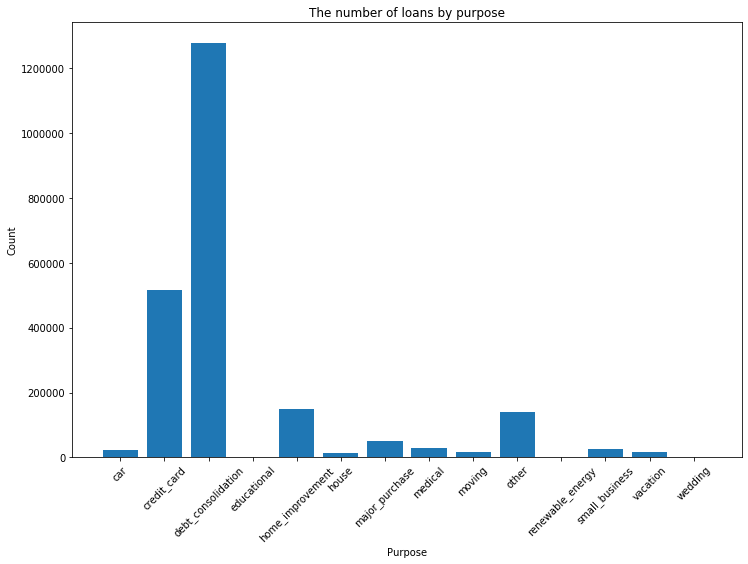


####################

THE AVERAGE FUNDED AMOUNT OF LOANS BY PURPOSE


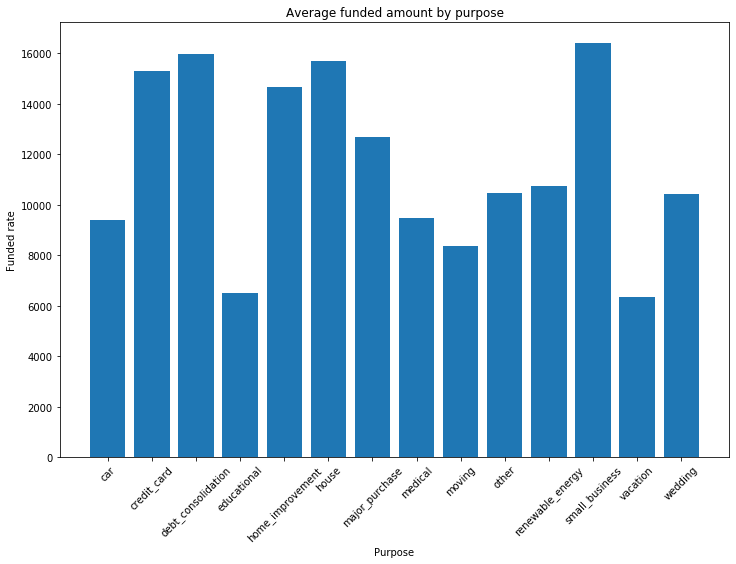


####################

THE AVERAGE INTEREST RATE OF LOANS BY PURPOSE


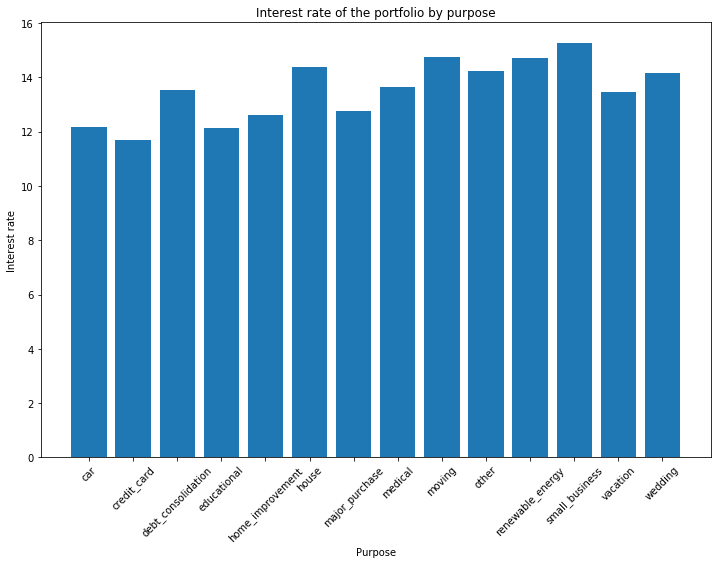


####################

THE AVERAGE DEFAULT RATE OF LOANS BY PURPOSE


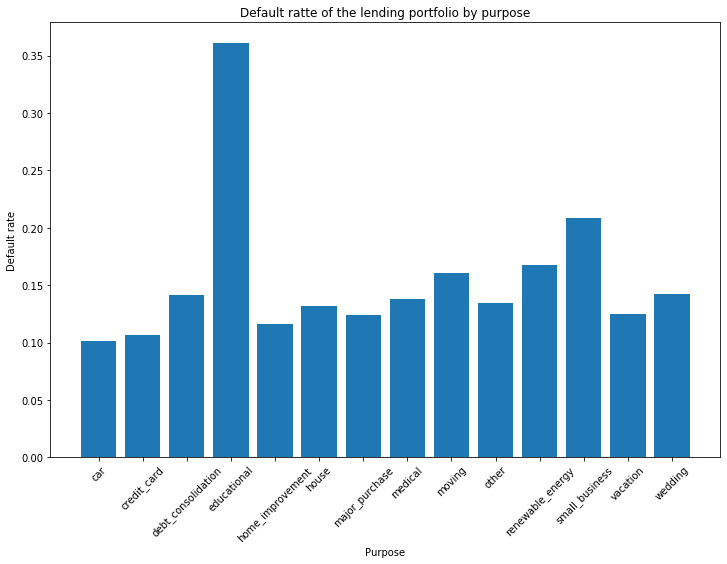

In [6]:
print('THE NUMBER OF LOANS BY PURPOSE')
#create a 'background'
plt.figure(figsize = (12,8))
#plot a bar graph
plt.bar(data_exp.groupby('purpose').size().index, data_exp.groupby('purpose').size())
#label axes
plt.xlabel('Purpose')
plt.ylabel('Count')
#name the table
plt.title("The number of loans by purpose")
#rotate x tick values
plt.xticks(rotation='45')
#show the plot
plt.show()

print('')
print('####################')
print('')

print('THE AVERAGE FUNDED AMOUNT OF LOANS BY PURPOSE')
plt.figure(figsize = (12,8))
plt.bar(by_prod.index.tolist(), by_prod.funded_amnt)
plt.xlabel('Purpose')
plt.ylabel('Funded rate')
plt.title("Average funded amount by purpose")
plt.xticks(rotation='45')
plt.show()

print('')
print('####################')
print('')

print('THE AVERAGE INTEREST RATE OF LOANS BY PURPOSE')
plt.figure(figsize = (12,8))
plt.bar(by_prod.index.tolist(), by_prod.int_rate)
plt.xlabel('Purpose')
plt.ylabel('Interest rate')
plt.title("Interest rate of the portfolio by purpose")
plt.xticks(ticks = None, rotation='45')
plt.show()

print('')
print('####################')
print('')

print('THE AVERAGE DEFAULT RATE OF LOANS BY PURPOSE')
plt.figure(figsize = (12,8))
plt.bar(by_prod.index.tolist(), 1-by_prod.loan_status, label = 'Default rate')
plt.xlabel('Purpose')
plt.ylabel('Default rate')
plt.title("Default ratte of the lending portfolio by purpose")
plt.xticks(rotation='45')
plt.show()



**Examine how Lending Club grew over years**

In [7]:
#extract year and month from issue_d for further analyses
data_exp['issue_d'] = data_exp['issue_d'].fillna('Dec-2007')
data_exp['year'] = data_exp.issue_d.apply(lambda x: int(x.split('-')[1]))
#group loan by year and purpose
year_purpose = data_exp.groupby(['year','purpose']).size().to_frame('number')
year_purpose.reset_index(level = ('year','purpose'), inplace = True)

Text(0.5, 1.0, 'The number of loans issued by year')

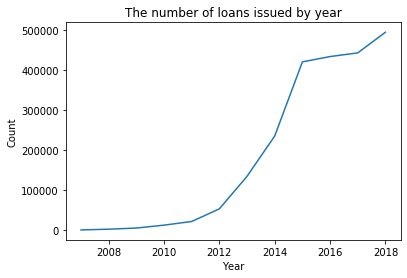

In [8]:
#create x axis
x = range(2007,2019)
#count the total of loans by year
total_loans = [sum(year_purpose[year_purpose.year == i].number) for i in x]
#plot a line graph
plt.plot(x, total_loans)
#label axes
plt.xlabel('Year')
plt.ylabel('Count')
#name the table
plt.title("The number of loans issued by year")

# II. Variable matching

In [9]:
#list of variables that are available to Lending Club's investors before loans are accepted
#Mismatching due to typos was processed using python mannually and the final result is added to the 'infor_before_aprroval' sheet
var_desc_before = pd.read_excel('LCDataDictionary.xlsx', sheet_name=2)
var_all_before  = list(var_desc_before['infor_before_aprroval'].dropna())
print(var_all_before)

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc_joint', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'desc', 'dti', 'dti_joint', 'emp_title', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'verification_status', 'loan_amnt', 'max_bal_bc', 'member_id', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_major_derog', 'mo_sin_old_il_acct', 'mths_since_rcnt_il', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_recent_inq', 'mths_since_recent_bc', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl

# III. Data preprocessing

**Quantify categorical variables**

In [10]:
#List of categorical variables
cate_var = [column for column in var_all_before if accepted.dtypes[column] == 'object']
print(cate_var)

['addr_state', 'application_type', 'desc', 'emp_title', 'emp_length', 'grade', 'home_ownership', 'id', 'initial_list_status', 'verification_status', 'purpose', 'sub_grade', 'term', 'title', 'url', 'verification_status_joint', 'zip_code', 'sec_app_earliest_cr_line', 'disbursement_method', 'loan_status']


In [11]:
#quantify emp_length

accepted.emp_length = accepted.emp_length.fillna('0 year')
def replace_year(x):
    """
    function: convert emp_length values from str to int
    input: emp_length column of the dataset
    output: numericalized version of the emp_lenth column
    """
    #assign '10+ years' to ''10 years':'
    if x =='10+ years':
        x = '10 years'
    elif  x == '< 1 year' or x == np.float('nan'):
        x = '0 year'
    #remove ' years' and convert to integer
    x = int(x.split(' ')[0])
    return(x)

accepted['emp_length'] = accepted.emp_length.apply(lambda x: replace_year(x))
# accepted.drop('emp_length', axis = 1, inplace = True)

In [12]:
#quantify term

def replace_term(x):
    """
    function: convert term values from str to int
    input: term column of the dataset
    output: numericalized version of the term column
    """
    #convert to suitable int values
    if x == ' 36 months':
        x = 36
    elif x == ' 60 months':
        x = 60
    return(x)

accepted['term'] = accepted.term.apply(lambda x: replace_term(x))
# sum(accepted.term.isna()) = 31 -> can drop na value
accepted = accepted[accepted.term.notna()]

In [13]:
# quantify verification_status

def replace_veri(x):
    """
    function: convert verification_status values from str to int
    input: verification_status column of the dataset
    output: numericalized version of the verification_status column
    """
    #numericalize unique values of the variable
    if x == 'Not Verified':
        x = 0
    else:
        x = 1
    return(x)

accepted['verification_status'] = accepted.verification_status.apply(lambda x: replace_veri(x))

In [14]:
# quantify disbursement_method
def replace_disbur(x):
    """
    function: convert disbursement_method values from str to int
    input: disbursement_method column of the dataset
    output: numericalized version of the disbursement_method column
    """
    #numericalize unique values of the variable
    if x == 'DirectPay':
        x = 0
    else:
        x = 1
    return(x)

accepted['disbursement_method'] = accepted.disbursement_method.apply(lambda x: replace_disbur(x))

In [15]:
# quantify initial_list_status
def replace_list_status(x):
    """
    function: convert initial_list_status values from str to int
    input: initial_list_status column of the dataset
    output: numericalized version of the initial_list_status column
    """
    #numericalize unique values of the variable
    if x == 'w':
        x = 0
    else:
        x = 1
    return(x)

accepted['initial_list_status'] = accepted.initial_list_status.apply(lambda x: replace_list_status(x))

In [16]:
# quantify accplication_type status
def replace_app_status(x):
    """
    function: convert application_type values from str to int
    input: application_type column of the dataset
    output: numericalized version of the application_type column
    """
    #numericalize unique values of the variable
    if x == 'Individual':
        x = 1
    else:
        x = 0
    return(x)

accepted['application_type'] = accepted.application_type.apply(lambda x: replace_app_status(x))

In [17]:
# remove quantified variables from the list of categorical variables
cate_var = list(set(cate_var)-set(['emp_length', 'term', 'verification_status', 'disbursement_method', 'initial_list_status', 'application_type']))

**Check missing values and data segmentation**

In [18]:
#list of numerical data
num_var = list(set(var_all_before) - set(cate_var))
print(num_var)

['total_bc_limit', 'sec_app_fico_range_low', 'revol_bal', 'installment', 'open_il_12m', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc', 'int_rate', 'max_bal_bc', 'member_id', 'num_rev_tl_bal_gt_0', 'delinq_amnt', 'acc_open_past_24mths', 'tot_hi_cred_lim', 'total_bal_il', 'open_act_il', 'dti', 'num_actv_rev_tl', 'open_il_24m', 'total_acc', 'num_tl_90g_dpd_24m', 'funded_amnt', 'total_cu_tl', 'num_op_rev_tl', 'num_tl_op_past_12m', 'sec_app_open_acc', 'sec_app_inq_last_6mths', 'mths_since_last_record', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'open_acc_6m', 'collections_12_mths_ex_med', 'mths_since_recent_revol_delinq', 'verification_status', 'tot_coll_amt', 'pub_rec', 'total_bal_ex_mort', 'acc_now_delinq', 'open_rv_12m', 'mths_since_last_delinq', 'pub_rec_bankruptcies', 'chargeoff_within_12_mths', 'mo_sin_rcnt_tl', 'open_rv_24m', 'tax_liens', 'percent_bc_gt_75', 'revol_util', 'num_tl_30dpd', 'pct_tl_nvr_dlq', 'sec_app_fico_range_high', 'emp_length', 'sec_

In [19]:
#check %na values of each variable

#Create a table in which rows represent %na value of each variable and #column is debt_consolidation
missing_table = accepted[num_var][accepted.purpose == 'debt_consolidation'].isna().mean()
missing_table = missing_table.to_frame(name = 'debt_consolidation')

#Compute %na value of other product segment by variables, then add the result to the missing_table
purpose_list = ['small_business', 'home_improvement', 'major_purchase', 'credit_card', 'other', 'house', 'vacation','car', 'medical', 'moving', 'renewable_energy', 'wedding','educational']
#loop through every purpose
for i in range(13):
    #calculate %na values of variables
    missing = accepted[num_var][accepted.purpose == purpose_list[i]].isna().mean()
    #Add the obtained information to missing_table
    missing_table[purpose_list[i]] = missing
    


In [20]:
missing_table.sort_values(by ='debt_consolidation')

,debt_consolidation,small_business,home_improvement,major_purchase,credit_card,other,house,vacation,car,medical,moving,renewable_energy,wedding,educational
initial_list_status,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
emp_length,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
term,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
application_type,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
verification_status,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sec_app_open_act_il,0.950755,0.958078,0.938906,0.953117,0.960466,0.951162,0.959536,0.959485,0.956399,0.923348,0.946049,0.954325,1.0,1.0
sec_app_inq_last_6mths,0.950755,0.958078,0.938906,0.953117,0.960466,0.951162,0.959536,0.959485,0.956399,0.923348,0.946049,0.954325,1.0,1.0
sec_app_revol_util,0.951410,0.959294,0.940328,0.954723,0.960739,0.953112,0.961234,0.960644,0.959064,0.926550,0.950269,0.956401,1.0,1.0
sec_app_mths_since_last_major_derog,0.983438,0.984406,0.977681,0.982476,0.989680,0.980371,0.984932,0.984734,0.983342,0.970860,0.974485,0.975779,1.0,1.0


Of major products, debt_conslidation has the largest number of variables with %na values below 0.1
Given the limited information about na values in values I try to avoid dealing with na values as much as possible. That's why I will proceed with debt_conslidation segment. From the business side, developing a PD model for this segment is most value able because of its dominance in the lending portfolio of Lending Club

In [21]:
#data of debt_consolidation loans only
cons = accepted[accepted.purpose == 'debt_consolidation']

In [22]:
#list of variables having less than 10% na values
ok_var = list(missing_table[missing_table.debt_consolidation < 0.1].index)

# IV. Variable selection

**Pearson correlation**

In [23]:
#keep qualified numerical and categorical variables
cons1 = cons[ok_var+cate_var]

In [24]:
#calculate Pearson correlation of numerical variables 
corr = cons1.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
corr[mask] = 0
size = len(ok_var)-1

# print out pairs that have correlation coefficients not in range [-0.8, 0.8]
cor_var = []
for col in range(0,size):
    for row in range(col+1,size):
        if corr.iloc[row, col] > 0.8 or corr.iloc[row, col] < -0.8:
            cor_var.append([ok_var[col], ok_var[row], corr.iloc[row, col]])
cor_var = pd.DataFrame(cor_var,columns=['Variable 1','Variable 2','Pearson correlation'])
cor_var

,Variable 1,Variable 2,Pearson correlation
0,total_bc_limit,bc_open_to_buy,0.846357
1,revol_bal,total_rev_hi_lim,0.801016
2,installment,funded_amnt,0.939884
3,installment,loan_amnt,0.939547
4,num_rev_tl_bal_gt_0,num_actv_rev_tl,0.982089
5,num_rev_tl_bal_gt_0,num_op_rev_tl,0.804805
6,num_rev_tl_bal_gt_0,num_actv_bc_tl,0.803250
7,tot_hi_cred_lim,tot_cur_bal,0.977040
8,num_actv_rev_tl,num_op_rev_tl,0.800564
9,num_actv_rev_tl,num_actv_bc_tl,0.810176


In [25]:
#Variables that should be removed removed based on the correlation result and objective assessment
drop_var = ['funded_amnt', 'installment', 'bc_open_to_buy', 'num_tl_30dpd', 'num_bc_tl', 'num_rev_accts', 'total_il_high_credit_limit',
           'num_actv_bc_tl','num_op_rev_tl', 'num_sats', 'bc_util', 'fico_range_low', 'tot_cur_bal', 'tot_hi_cred_lim', 'num_rev_tl_bal_gt_0', 'total_rev_hi_lim']

#numerical variables left after the correlation test
num_aft_cor = list(set(ok_var)-set(drop_var))
print(num_aft_cor)

['emp_length', 'total_bc_limit', 'term', 'revol_bal', 'mo_sin_old_rev_tl_op', 'application_type', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc', 'int_rate', 'num_il_tl', 'num_tl_120dpd_2m', 'delinq_amnt', 'initial_list_status', 'acc_open_past_24mths', 'num_bc_sats', 'dti', 'num_actv_rev_tl', 'open_acc', 'fico_range_high', 'total_acc', 'num_tl_90g_dpd_24m', 'avg_cur_bal', 'mo_sin_old_il_acct', 'mort_acc', 'num_tl_op_past_12m', 'num_accts_ever_120_pd', 'collections_12_mths_ex_med', 'pub_rec', 'verification_status', 'tot_coll_amt', 'delinq_2yrs', 'total_bal_ex_mort', 'acc_now_delinq', 'disbursement_method', 'pub_rec_bankruptcies', 'chargeoff_within_12_mths', 'mo_sin_rcnt_tl', 'inq_last_6mths', 'tax_liens', 'percent_bc_gt_75', 'revol_util', 'pct_tl_nvr_dlq', 'annual_inc', 'loan_amnt']


In [26]:
# Check if there is no correlated variables left. If an empty list is returned, all correlated variables are removed

corr1 = cons1[num_aft_cor].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr1, dtype=bool))
corr1[mask] = 0
x = len(num_aft_cor)-1
cor_var1 = []
for col in range(0,x):
    for row in range(col+1,x):
#         print(row,col)
        if corr1.iloc[row, col] > 0.8 or corr1.iloc[row, col] <= -0.8:
            cor_var1.append([num_aft_cor[col], num_aft_cor[row], corr1.iloc[row, col]])
cor_var1

[]

**Cramer correlation**

In [27]:
#why some categorical variables are removed to avoid wasting computational power
"""
url, id, desc: are irrelevant
zip_code: correlate with addr_state
emp_title: has too many unique values
grade and sub_grade: internally graded by LC, should not add them to the model
purpose and title: all data points have 'debt_consolidation' value in these variables
sec_app_earliest_cr_line, verification_status_joint: has too many na values
"""

cate_var = list(set(cate_var)-set(['url', 'zip_code', 'emp_title', 'sub_grade', 'grade','desc','id', 'title', 'sec_app_earliest_cr_line', 'purpose', 'verification_status_joint']))
print(cate_var)

['addr_state', 'home_ownership', 'loan_status']


In [28]:
#source: https://www.kaggle.com/pavlofesenko/minimizing-risks-for-loan-investments
# Cramer correlation test
comb_cat_feat = np.array(list(combinations(cate_var, 2)))
corr_cat_feat = np.array([])
for comb in comb_cat_feat:
    table = pd.pivot_table(cons1, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corr_cat_feat = np.append(corr_cat_feat, corr)
corr_cat_feat

array([0.11309381, 0.0294554 , 0.03424985])

There are no highly correlated variables, so no variable is dropped at this stage. Now, we can proceed with selecting qualified numerical and categorical variables

**Finalize variables and deal with na values**

In [29]:
#variables that are qualified for the model development
final_var = num_aft_cor + cate_var
#select qualified variables only
cons1 = cons1[final_var]


In [30]:
#Assign good loans to 1 and unperforming loans to 0
cons1['loan_status'] = cons1.loan_status.apply(lambda x: 1 if x in ['Fully Paid', 'Current', 'In Grace Period'] else 0 )

In [31]:
print('Ratio of good and bad borrowers before dropping na:', sum(cons1.loan_status == 1)/len(cons1))
print('Ratio of good and bad borrowers after dropping na:', sum(cons1.dropna().loan_status == 1)/len(cons1.dropna()))

Ratio of good and bad borrowers before dropping na: 0.8582555285054821
Ratio of good and bad borrowers after dropping na: 0.8619691877973203


As the ratio of good and bad borrowers does not change much after all na values are drop, there is no bias introduced to the dataset as a result of this action. So we can proceed the model development process by droping all na values

In [32]:
#drop borrowers having na values
cons1 = cons1.dropna()

In [33]:
#copy a version of cons 1 to develop multiple models easily
import copy
origin = copy.copy(cons1)

# V. Model developemt

**Define necessary functions**

In [34]:
#area under the curve - borrowed from Quan Tran M21
import matplotlib.pyplot as plt
from sklearn import metrics
def plot_roc(fpr, tpr, auc):
    """
    function: plot the ROC curve
    input: false positive rate, true positiva rate, calculated AUROC
    output: the graph of the ROC curve 
    """
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('AUC for validation is: %0.2f' % auc)
    plt.show()
    
#distribution plot
import seaborn as sns
def density_plot(pred_proba, label):
    """
    function: plot distribution of good and bad borrowers on the scacle of the predicted default probability.
    The purpose is to examine if the two population is separated by the predicted default probability
    input: the predicted default probability of borrowers, and the true outcome of their loans  
    output: distribution of two populations
    """
    #create list to record index of two types of borrwers
    class1 = []
    class0 = []
    #as label is in list format, we will loop through every element to check what type of borrower it is
    for i in range(len(label)):
        if label[i] == 1:
            class1.append(i)
        else:
            class0.append(i)
    
    #distribution plot
    sns.distplot(pred_proba[:,0][class1], hist = False,kde_kws={'clip': (0.0, 1.0)}, label = 'Class 1')
    sns.distplot(pred_proba[:,0][class0], hist = False, kde_kws={'clip': (0.0, 1.0)}, label = 'Class 0')
    plt.title('Density distribution of 2 classes')

In [35]:
#one-hot encode function
def onehot_encode(df, column):
    """
    apply onehot encoding techniques on categorical variable
    input:
        df: the dataframe
        column: column name in the df 
    output: the dataframe having the specified column onehot encoded
    """
    #create dummy columns
    dummies = pd.get_dummies(df[column])
    #concatenate dummy columns to the table
    df_new = pd.concat([df, dummies], axis=1)
    #drop the original variable from the dataset
    df_new = df_new.drop(column, axis=1)
    return df_new

## Experimental method:


Using this method, independent variables are not carefully selected. For example, all uncorrelated variables are passed to the model without assessing their statistical and practical impacts on the target variables. 

### Model 1: All uncorrelated independent variables are used

In [36]:
#THE CODE REPEATS FOR ALL MODELS BELOW, SO ONLY THIS CELL IS THOROUGHLY ANNOTATED

#load data from the origin version
cons1 = copy.copy(origin)

#apply onehot_encoding to categorical variables
cons1 = onehot_encode(cons1, 'addr_state')
cons1 = onehot_encode(cons1, 'home_ownership')

#Split predcitors from the target variable
y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)

#standardize predictors
X = (X-X.mean())/X.std()

X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

Classification report for classifier LogisticRegression(C=100000, class_weight={0: 86, 1: 14}, max_iter=10000):
              precision    recall  f1-score   support

           0       0.23      0.66      0.34     47535
           1       0.92      0.64      0.76    296160

    accuracy                           0.65    343695
   macro avg       0.58      0.65      0.55    343695
weighted avg       0.83      0.65      0.70    343695



*********

accuracy :
0.65
f-score is :
0.76
precision score is :
0.92


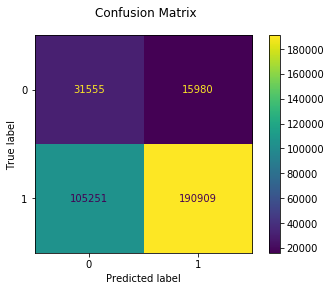


*********



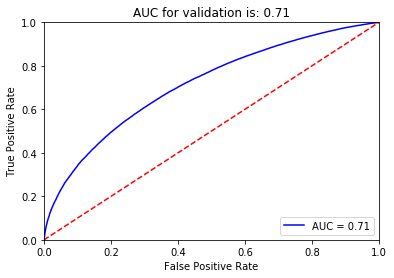


*********

Max difference 0.309

*********



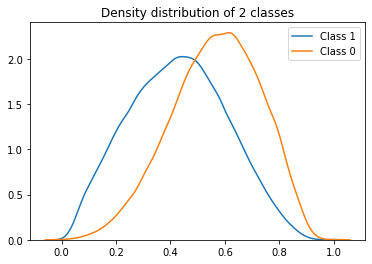


*********



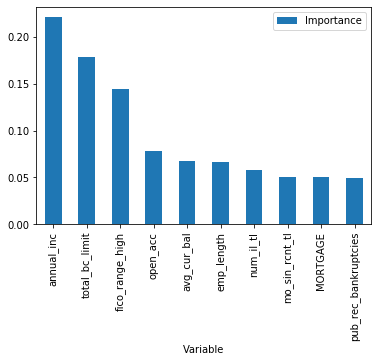

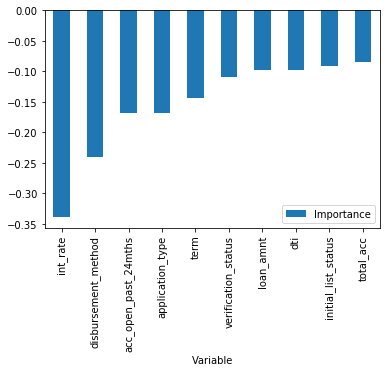

In [37]:
#THE CODE REPEATS FOR ALL MODELS BELOW, SO ONLY THIS CELL IS THOROUGHLY ANNOTATED

#define a logistic regresion model
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100000)
#fit the model on the training data
lf.fit(X_train, y_train)
#make prediction on the test data
loan_pred = lf.predict(X_test)
#get the predicted probability
loan_pred_prob = lf.predict_proba(X_test)

#plot the confusion metric
print("Classification report for classifier %s:\n%s\n"
      % (lf, metrics.classification_report(y_test, loan_pred)))
disp = metrics.plot_confusion_matrix(lf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print('')
print('*********')
print('')

#calculate relevant ratios from the confusion matrix
print("accuracy :\n%s" % np.round(metrics.accuracy_score(y_test, loan_pred), 2))
print("f-score is :\n%s" % np.round(metrics.f1_score(y_test, loan_pred), 2))
print("precision score is :\n%s" % np.round(metrics.precision_score(y_test, loan_pred), 2))
plt.show()
print('')
print('*********')
print('')

#plot the ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, loan_pred_prob[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plot_roc(fpr, tpr, auc)
plt.show()

print('')
print('*********')
print('')

#calculate the KS difference
population1 = loan_pred_prob[:,0][y_test == 1]
population0 = loan_pred_prob[:,0][y_test == 0]
max_error, p_value = sts.ks_2samp(population1, population0)
print(f"Max difference {max_error:2.3f}")

print('')
print('*********')
print('')

#plot the distribution of good and bad loans
density_plot(loan_pred_prob, y_test.to_list())
plt.show()

print('')
print('*********')
print('')

#Create the coefficient of variables
#get the coefficient estimates
coefficient = lf.coef_[0]
#create a list to store the variable's name and its coefficient
var_list = []
imp_list = []
#loop through the coefficient table and extract data to 2 lists created above
for variable, importance in enumerate(coefficient):
    var_list.append(X.columns.values[variable])
    imp_list.append(importance)
#create dataframe structure
importance_table = pd.DataFrame({'Variable':var_list, 'Importance':imp_list})
#plot 10 highest coefficients
importance_table = importance_table.sort_values(by = 'Importance', ascending = False)
ax = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')

#plot 10 lowsest coefficients
importance_table = importance_table.sort_values(by = 'Importance', ascending = True)
ax = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')


In [38]:
#print all coefficients in the model in the ascending order
pd.set_option('display.max_rows', 120)
importance_table

,Variable,Importance
0,int_rate,-0.339535
37,disbursement_method,-0.239919
2,acc_open_past_24mths,-0.168338
14,application_type,-0.168262
43,term,-0.144686
35,verification_status,-0.109416
20,loan_amnt,-0.098050
19,dti,-0.098002
32,initial_list_status,-0.091093
10,total_acc,-0.084910


The result is decent, but the model still has too many variables, high complexity. To reduce the complexity, address and application_type will be removed from the next model. Also, the importance order of variables, by their coefficient estimates, does not make sense practically. For example, the disbursement_method is more influential than annual income. Therefore, in the next mode, addr_state and application_type will be removed to reduce the model complexity. At the same time, the importance order of variables will also be paid attention to

### Model 2: addr_state + application_type are removed, annual_inc and loan_amnt are combined to create annual_inc/loan_amt

In [39]:
cons1 = copy.copy(origin)

cons1['inc/loan'] = cons1.annual_inc/cons1.loan_amnt
cons1 = cons1.drop(['addr_state', 'application_type', 'initial_list_status', 'annual_inc', 'loan_amnt', 'disbursement_method'], axis = 1)

cons1 = onehot_encode(cons1, 'home_ownership')

y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)
X = (X-X.mean())/X.std()
X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

Classification report for classifier LogisticRegression(C=100000, class_weight={0: 86, 1: 14}, max_iter=10000):
              precision    recall  f1-score   support

           0       0.23      0.65      0.34     47535
           1       0.92      0.65      0.76    296160

    accuracy                           0.65    343695
   macro avg       0.57      0.65      0.55    343695
weighted avg       0.82      0.65      0.70    343695



*********

accuracy :
0.65
f-score is :
0.76
precision score is :
0.92


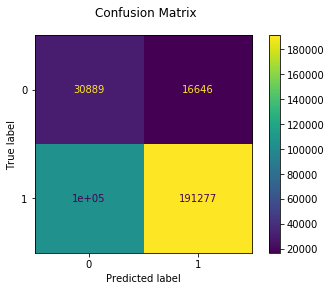


*********



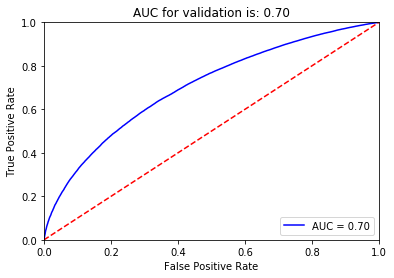


*********

Max difference 0.297

*********



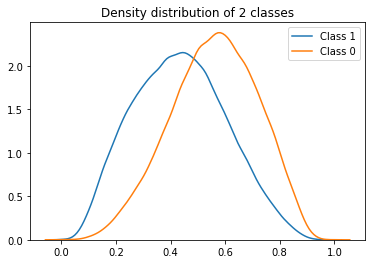


*********



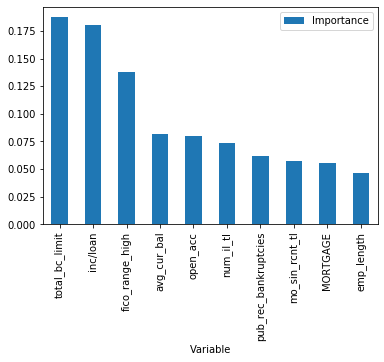

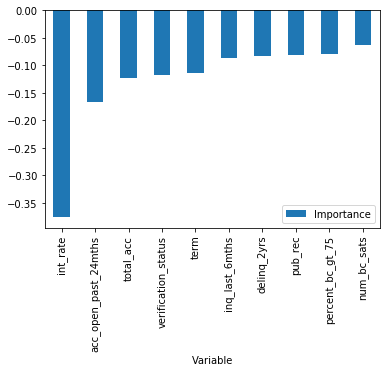

In [40]:
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100000)
lf.fit(X_train, y_train)
loan_pred = lf.predict(X_test)
loan_pred_prob = lf.predict_proba(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (lf, metrics.classification_report(y_test, loan_pred)))
disp = metrics.plot_confusion_matrix(lf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print('')
print('*********')
print('')

print("accuracy :\n%s" % np.round(metrics.accuracy_score(y_test, loan_pred), 2))
print("f-score is :\n%s" % np.round(metrics.f1_score(y_test, loan_pred), 2))
print("precision score is :\n%s" % np.round(metrics.precision_score(y_test, loan_pred), 2))
plt.show()
print('')
print('*********')
print('')

fpr, tpr, thresholds = metrics.roc_curve(y_test, loan_pred_prob[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plot_roc(fpr, tpr, auc)
plt.show()

print('')
print('*********')
print('')

population1 = loan_pred_prob[:,0][y_test == 1]
population0 = loan_pred_prob[:,0][y_test == 0]
max_error, p_value = sts.ks_2samp(population1, population0)
print(f"Max difference {max_error:2.3f}")

print('')
print('*********')
print('')

density_plot(loan_pred_prob, y_test.to_list())
plt.show()

print('')
print('*********')
print('')

coefficient = lf.coef_[0]
var_list = []
imp_list = []
for variable, importance in enumerate(coefficient):
    var_list.append(X.columns.values[variable])
    imp_list.append(importance)
importance_table = pd.DataFrame({'Variable':var_list, 'Importance':imp_list})
importance_table = importance_table.sort_values(by = 'Importance', ascending = False)
a1 = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')

importance_table = importance_table.sort_values(by = 'Importance', ascending = True)
a2 = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')



In [41]:
pd.set_option('display.max_rows', 120)
print(importance_table)

                      Variable  Importance
0                     int_rate   -0.376158
2         acc_open_past_24mths   -0.165984
10                   total_acc   -0.122395
31         verification_status   -0.117817
38                        term   -0.113756
32              inq_last_6mths   -0.086826
27                 delinq_2yrs   -0.082224
1                      pub_rec   -0.080851
13            percent_bc_gt_75   -0.079110
9                  num_bc_sats   -0.062925
45                        RENT   -0.054839
21              pct_tl_nvr_dlq   -0.048293
34                  revol_util   -0.047655
18                         dti   -0.032929
24              acc_now_delinq   -0.012987
4   collections_12_mths_ex_med   -0.011079
15       mo_sin_rcnt_rev_tl_op   -0.010252
28          num_tl_op_past_12m   -0.008407
19                 delinq_amnt   -0.008361
43                       OTHER   -0.005169
36           total_bal_ex_mort   -0.004547
44                         OWN   -0.003205
26         

In this model, the complexity is reduced significantly while the efficiency metrics stay the same. However, the importance order of variables is quite sensitive and does not make sense practically. For example, the debt to income ratio (dti) is less influential than the number of satisfactory accounts (num_bc_sats).

**In conclusion:** Although the experiment method produces stable results, its practical meaning is questionable. The importance order of variables does not make sense practically. Additionally, the importance order varies quite significantly over iterations. This poses obstacles to modify the model over iterations as we do not know what order we should base our adjustments on. 
In fact, many other models were implemented using the experiment method, but there was no model whose accuracy, simplicity, and practical meaning clearly outweigh others. As a result, the experimental method is not recommended for banks to develop their models in practice as it is time and computation consuming, even impossible, to find a model whose accuracy is high enough while the importance ranking of variables is practically justifiable

# VI. Model modification

Realizing difficulties in optimizing and interpreting the result using the experimental method, models in this section will be modified with a more systemic approach using the RFE test and the qualitative assessment.


### Variable selection: RFE test

The purpose of this test is to eliminate variables having little impact on the default probability of a loan statistically and practically. Firstly, the RFE analysis will be implemented to find out 20 most influential variables. 

In [42]:
#Perform RFE analysis to find 20 most influential variables.
cons1 = copy.copy(origin)

cons1 = onehot_encode(cons1, 'addr_state')
cons1 = onehot_encode(cons1, 'home_ownership')

y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)
X = (X-X.mean())/X.std()

X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

from sklearn.feature_selection import RFE
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100000)
selector = RFE(lf, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)

impor_table = pd.DataFrame({'Order':selector.ranking_, 'Variable':X_train.columns})
impor_table.sort_values(by = 'Order').Variable[:20].values
impor_table.sort_values(by = 'Order')

,Order,Variable
0,1,int_rate
3,2,fico_range_high
37,3,disbursement_method
34,4,annual_inc
2,5,acc_open_past_24mths
14,6,application_type
35,7,verification_status
43,8,term
95,9,MORTGAGE
17,10,total_bc_limit


### Variable selection: Qualitative assessment

Next, 20 most influential variables will be assessed qualitatively to ensure the practical meaning of the final model. In practice, credit risk professionals will perform the assessment to select variables that are really important to the business strategies of their bank. However, as such inputs are impossible to achieve, I mimic the test using my subjective adjustment. Arguments used in the qualitative assessment are presented in the writeup. At the end, only 7 variables are selected

In [43]:
#7 selected variables are 
selected_var = ['int_rate', 'fico_range_high', 'annual_inc', 'application_type', 'dti',
                'term', 'home_ownership', 'loan_amnt', 'loan_status',]


### Model 3: The model only has 7 variables

In [44]:

cons1 = copy.copy(origin)
cons1 = cons1[selected_var]

cons1['inc/loan'] = cons1.annual_inc/cons1.loan_amnt
cons1 = cons1.drop(['annual_inc', 'loan_amnt'], axis = 1)

cons1 = onehot_encode(cons1, 'home_ownership')

y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)
X = (X-X.mean())/X.std()
X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

Classification report for classifier LogisticRegression(C=100000, class_weight={0: 86, 1: 14}, max_iter=10000):
              precision    recall  f1-score   support

           0       0.22      0.63      0.33     47535
           1       0.92      0.64      0.76    296160

    accuracy                           0.64    343695
   macro avg       0.57      0.64      0.54    343695
weighted avg       0.82      0.64      0.70    343695



*********

accuracy :
0.64
f-score is :
0.76
precision score is :
0.92


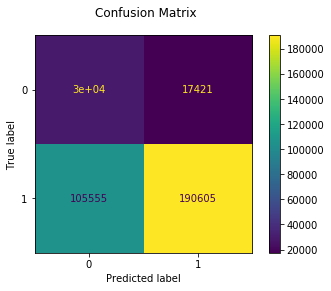


*********



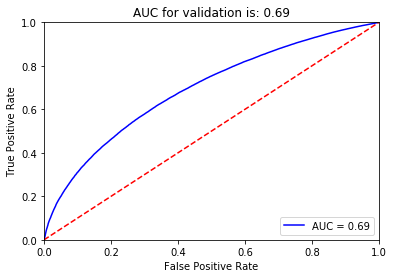


*********

Max difference 0.280

*********



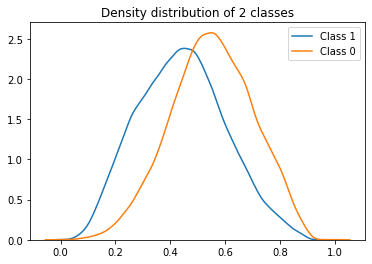


*********



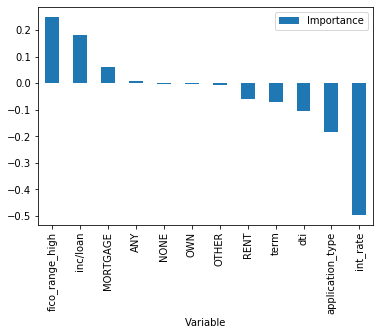

In [45]:
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100000)
lf.fit(X_train, y_train)
loan_pred = lf.predict(X_test)
loan_pred_prob = lf.predict_proba(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (lf, metrics.classification_report(y_test, loan_pred)))
disp = metrics.plot_confusion_matrix(lf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print('')
print('*********')
print('')

print("accuracy :\n%s" % np.round(metrics.accuracy_score(y_test, loan_pred), 2))
print("f-score is :\n%s" % np.round(metrics.f1_score(y_test, loan_pred), 2))
print("precision score is :\n%s" % np.round(metrics.precision_score(y_test, loan_pred), 2))
plt.show()

print('')
print('*********')
print('')

fpr, tpr, thresholds = metrics.roc_curve(y_test, loan_pred_prob[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plot_roc(fpr, tpr, auc)
plt.show()

print('')
print('*********')
print('')

population1 = loan_pred_prob[:,0][y_test == 1]
population0 = loan_pred_prob[:,0][y_test == 0]
max_error, p_value = sts.ks_2samp(population1, population0)
print(f"Max difference {max_error:2.3f}")

print('')
print('*********')
print('')

density_plot(loan_pred_prob, y_test.to_list())
plt.show()

print('')
print('*********')
print('')

coefficient = lf.coef_[0]
var_list = []
imp_list = []
for variable, importance in enumerate(coefficient):
    var_list.append(X.columns.values[variable])
    imp_list.append(importance)
importance_table = pd.DataFrame({'Variable':var_list, 'Importance':imp_list})
importance_table = importance_table.sort_values(by = 'Importance', ascending = False)
a1 = importance_table.head(13).plot.bar(x = 'Variable', y = 'Importance')

# importance_table = importance_table.sort_values(by = 'Importance', ascending = True)
# a2 = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')



In [46]:
pd.set_option('display.max_rows', 120)
print(importance_table)

            Variable  Importance
1    fico_range_high    0.250176
5           inc/loan    0.180975
7           MORTGAGE    0.059983
6                ANY    0.009815
8               NONE   -0.000656
10               OWN   -0.002541
9              OTHER   -0.005515
11              RENT   -0.060060
4               term   -0.070426
3                dti   -0.103603
2   application_type   -0.183846
0           int_rate   -0.494966


The result is surprising. It is slightly worse than model 2, but its practical meaning and simplicity are significantly improved. Therefore, I personally prefer this model to models 1 and 2. However, the coefficients of home_ownership's attributes look suspicious as most of them are close to 0. I will try to remove that variable in the next model to see if there is any significant change in the model's result

### Model 4: Remove home_ownership

In [47]:
selected_var = ['int_rate', 'fico_range_high', 'annual_inc', 'application_type', 'dti',
                'term', 'loan_amnt', 'loan_status',]

cons1 = copy.copy(origin)
cons1 = cons1[selected_var]

cons1['inc/loan'] = cons1.annual_inc/cons1.loan_amnt
cons1 = cons1.drop(['annual_inc', 'loan_amnt'], axis = 1)

y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)
X = (X-X.mean())/X.std()
X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

Classification report for classifier LogisticRegression(C=100, class_weight={0: 86, 1: 14}, max_iter=10000):
              precision    recall  f1-score   support

           0       0.22      0.63      0.33     47535
           1       0.92      0.64      0.76    296160

    accuracy                           0.64    343695
   macro avg       0.57      0.64      0.54    343695
weighted avg       0.82      0.64      0.70    343695



*********

accuracy :
0.64
f-score is :
0.76
precision score is :
0.92


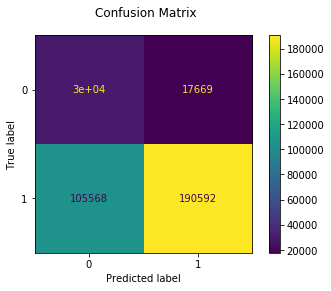


*********



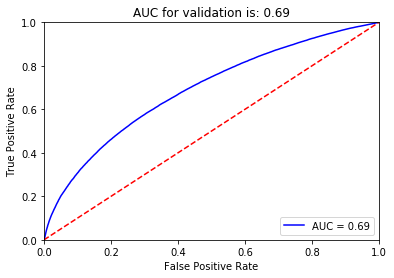


*********

Max difference 0.277

*********



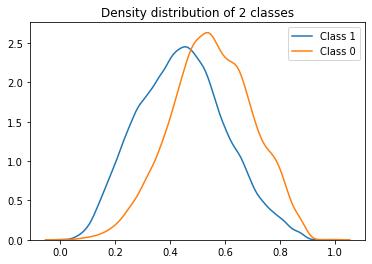


*********



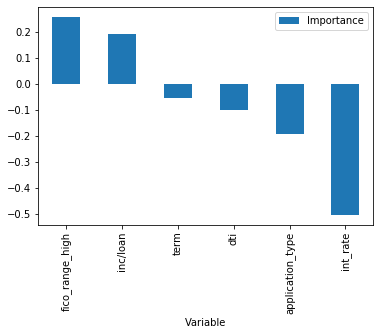

In [48]:
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100)
lf.fit(X_train, y_train)
loan_pred = lf.predict(X_test)
loan_pred_prob = lf.predict_proba(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (lf, metrics.classification_report(y_test, loan_pred)))
disp = metrics.plot_confusion_matrix(lf, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print('')
print('*********')
print('')

print("accuracy :\n%s" % np.round(metrics.accuracy_score(y_test, loan_pred), 2))
print("f-score is :\n%s" % np.round(metrics.f1_score(y_test, loan_pred), 2))
print("precision score is :\n%s" % np.round(metrics.precision_score(y_test, loan_pred), 2))
plt.show()

print('')
print('*********')
print('')

fpr, tpr, thresholds = metrics.roc_curve(y_test, loan_pred_prob[:,1], pos_label=1)
auc = metrics.auc(fpr, tpr)
plot_roc(fpr, tpr, auc)
plt.show()

print('')
print('*********')
print('')

population1 = loan_pred_prob[:,0][y_test == 1]
population0 = loan_pred_prob[:,0][y_test == 0]
max_error, p_value = sts.ks_2samp(population1, population0)
print(f"Max difference {max_error:2.3f}")

print('')
print('*********')
print('')

density_plot(loan_pred_prob, y_test.to_list())
plt.show()

print('')
print('*********')
print('')

coefficient = lf.coef_[0]
var_list = []
imp_list = []
for variable, importance in enumerate(coefficient):
    var_list.append(X.columns.values[variable])
    imp_list.append(importance)
importance_table = pd.DataFrame({'Variable':var_list, 'Importance':imp_list})
importance_table = importance_table.sort_values(by = 'Importance', ascending = False)
a1 = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')

# importance_table = importance_table.sort_values(by = 'Importance', ascending = True)
# a2 = importance_table.head(10).plot.bar(x = 'Variable', y = 'Importance')



The model stays the same even after home_onwership is dropped. So I conclude that 6 variables used in model 6 are most optimal. I will try to improve the model further by tuning hyperparameters to find the most optimal setting in the logistic regression function

### Model 5: Tuning hyperparameters

In [49]:
selected_var = ['int_rate', 'fico_range_high', 'annual_inc', 'application_type', 'dti',
                'term', 'loan_amnt', 'loan_status',]

cons1 = copy.copy(origin)
cons1 = cons1[selected_var]

cons1['inc/loan'] = cons1.annual_inc/cons1.loan_amnt
cons1 = cons1.drop(['annual_inc', 'loan_amnt'], axis = 1)

y = cons1.loan_status
X = cons1.drop(['loan_status'], axis = 1)
X = (X-X.mean())/X.std()
lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100)

X_train, y_train, X_test, y_test = X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 11)

In [50]:
#source: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

lf = LogisticRegression(class_weight = {0:86, 1:14}, max_iter = 10000, C = 100)

solvers = ['lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lf, param_grid=grid, n_jobs=1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.689186 using {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.689185 (0.002355) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.689186 (0.002355) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.689185 (0.002355) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.689186 (0.002355) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.689185 (0.002355) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.689186 (0.002355) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.689185 (0.002355) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.689186 (0.002355) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Apparently the result does not improve much even after using gridsearchCV to tune hyperparameters.

**Conclusion:** Model 4 is the best as although its accuracy is slightly lower than models 1 and 2, it is simpler with only 6 variables. The model's simplicity is meaningful to the banking business as it means banks can assess loan requests more quickly with less information. More importantly, the model is practically justifiable as all independent variables are carefully selected using statistical and qualitative tests.

# END